In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.svm import SVC
import librosa
import librosa.display
import IPython.display as ipd
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import joblib
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


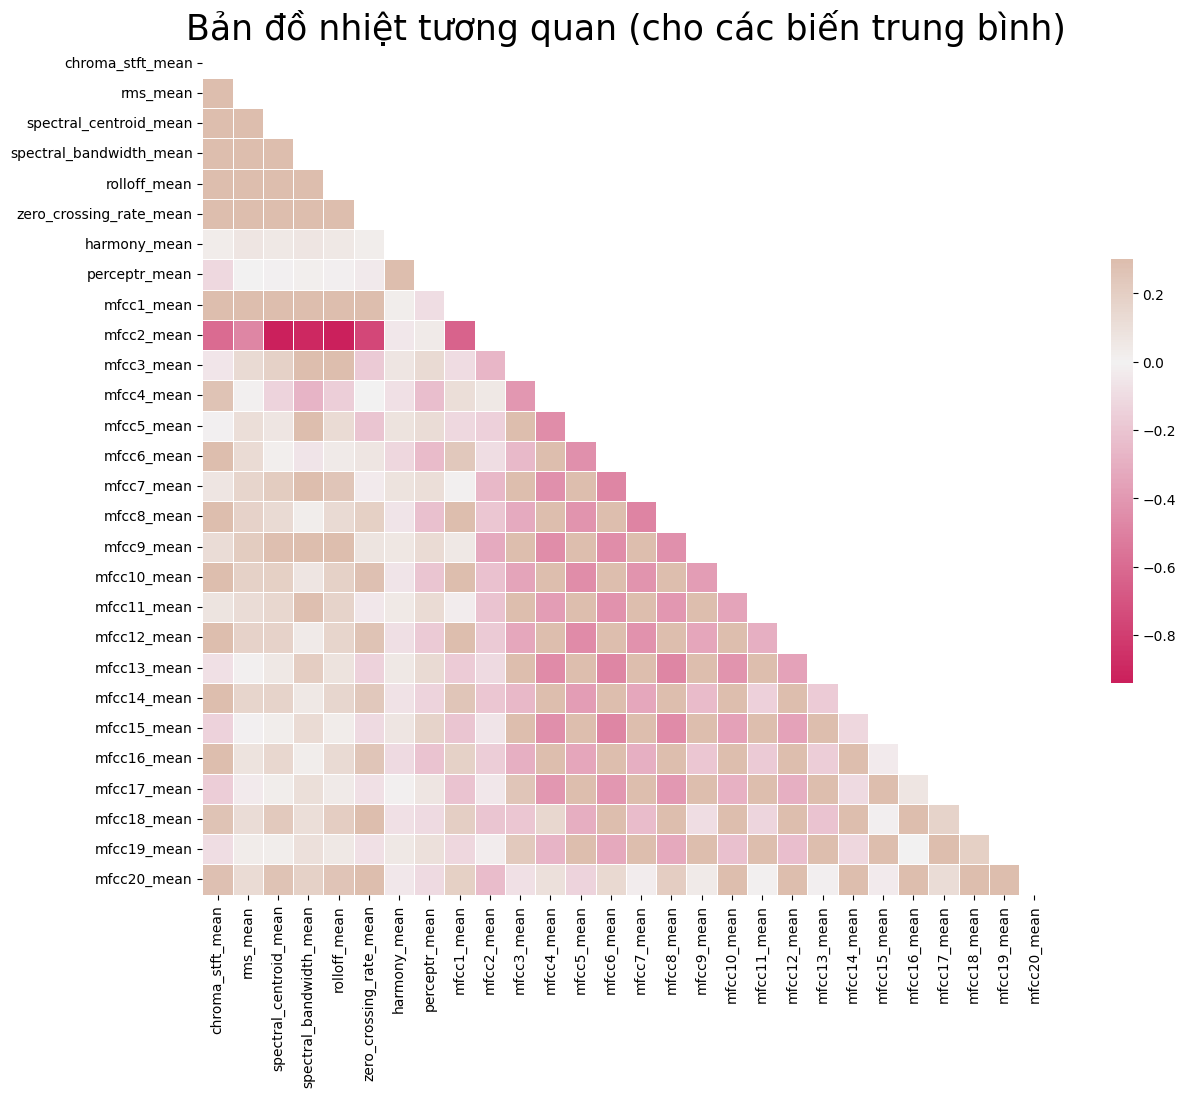

In [3]:
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 11));

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Bản đồ nhiệt tương quan (cho các biến trung bình)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

In [4]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# Chuẩn hóa dữ liệu
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


# Giảm chiều để về 2 chiều
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Thêm nhãn vào DataFrame
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

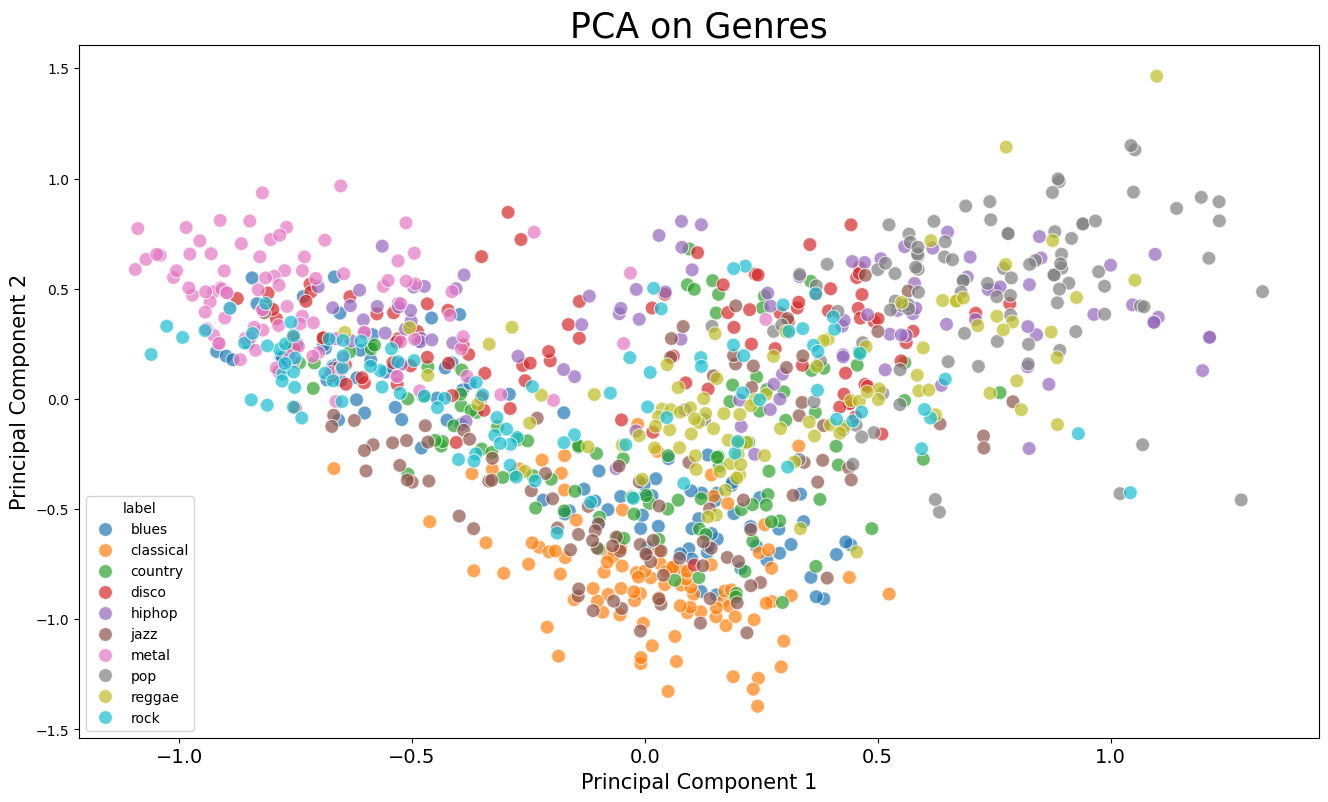

In [5]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")


In [6]:
data = pd.read_csv('features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [7]:
y = data['label'] 
X = data.loc[:, data.columns != 'label'] 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)


X = pd.DataFrame(np_scaled, columns = cols)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

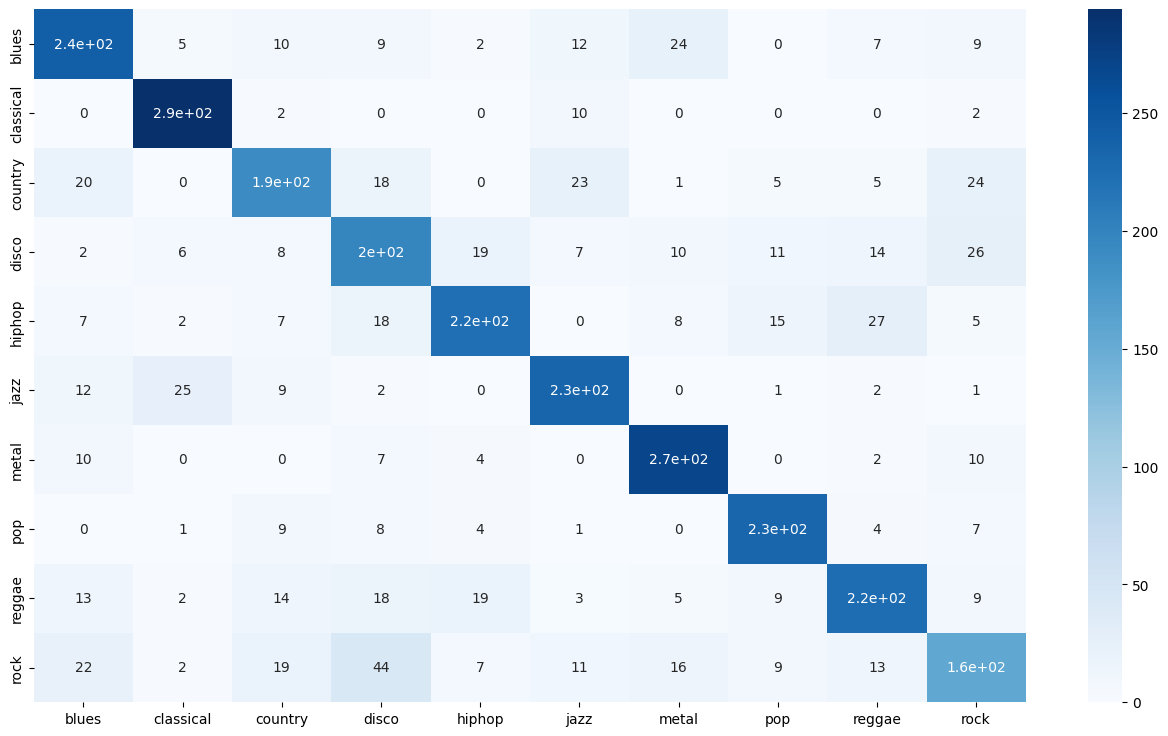

In [9]:
svm = SVC(decision_function_shape="ovo",class_weight='balanced', probability=True)
svm.fit(X_train, y_train)

preds = svm.predict(X_test)

confusion_matr = confusion_matrix(y_test, preds) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

In [10]:
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

Accuracy : 0.75509 



In [11]:
joblib.dump(svm, 'svm_model_Music.pkl')
joblib.dump(min_max_scaler, 'scaler_Music.pkl')

['scaler_Music.pkl']